# Spot-checking inicial: Gradient Boosting

## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [ ]:
! pip install pandas numpy matplotlib scikit-learn imbalanced-learn xgboost

### Importação de Bibliotecas
Na célula seguinte são importadas bibliotecas e métodos que serão utilizadas repetidamente ao longo da análise.

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from utils.visualization import (
    plot_metrics_by_class, print_summary_metrics,
    print_summary_metrics_latex
)

### Definição de Constantes Auxiliares
Na célula seguinte são definidas constantes utilitárias diversas que serão usadas ao longo da análise.

In [2]:
random_state = 42

max_depths = [3, 6, 8, 10, 15]

configs_to_test = [
    {
        "max_depth": max_depth, 
        "n_estimators": 100,
        "learning_rate": 0.1,
        "num_class": 3,
        "objective": "multi:softmax",
        "seed": random_state
    }
    for max_depth in max_depths
]

test_ratio = 0.15

train_ratio_holdout = 0.70
valid_ratio_holdout = 0.15

numeric_attrs = ["idade_paciente", "dias_sintomas_notificacao"]

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [3]:
df_sinan_processed = pd.read_csv("../data/3_gold/dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

### Particionamento dos Dados (Holdout)

In [5]:
# Fazendo a segunda divisão, para gerar o conjunto de treino e validação
final_test_size = valid_ratio_holdout / (train_ratio_holdout + test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=final_test_size, random_state=random_state, stratify=y_temp)

# Normalizando atributos numéricos
for col in numeric_attrs:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean) / (std + 1e-8)
    X_valid[col] = (X_valid[col] - mean) / (std + 1e-8)
    X_test[col] = (X_test[col] - mean) / (std + 1e-8)

print(f"Conjuntos gerados com as seguintes proporções: ")
print(f"  Treinamento: {X_train.shape}")
print(f"  Validação: {X_valid.shape}")
print(f"  Teste: {X_test.shape}")

Conjuntos gerados com as seguintes proporções: 
  Treinamento: (501841, 42)
  Validação: (107538, 42)
  Teste: (107538, 42)


## Amostragem de Dados

### Amostragem com SMOTE

In [7]:
class_counts = Counter(y_train)

print(f"Distribuição original das classes no conjunto de treinamento: {class_counts}")

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"Distribuição das classes após amostragem no conjunto de treinamento: {Counter(y_train_resampled)}")

Distribuição original das classes no conjunto de treinamento: Counter({0: 294594, 1: 187280, 2: 19967})
Distribuição das classes após amostragem no conjunto de treinamento: Counter({0: 187280, 1: 187280, 2: 187280})


In [8]:
f1_scores_valid = []
f1_scores_train = []

best_config_index = 0
max_f1_valid = 0

for i, config in enumerate(configs_to_test):
  dt = XGBClassifier(**config)
  dt.fit(X_train_resampled, y_train_resampled)

  y_pred = dt.predict(X_valid)
  f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
  f1_scores_valid.append(f1_valid)

  y_pred_train = dt.predict(X_train)
  f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
  f1_scores_train.append(f1_train)

  max_depth = config["max_depth"]
  print(f"Config: max_depth={max_depth}, F1 validação: {f1_valid:.3f}, F1 treino: {f1_train:.3f}")

  if f1_valid > max_f1_valid:
    max_f1_valid = f1_valid
    best_config_index = i

best_config = configs_to_test[best_config_index]
print(f"\nMelhor configuração: {best_config}, com F1 validação: {max_f1_valid:.3f}")

Config: max_depth=3, F1 validação: 0.508, F1 treino: 0.511
Config: max_depth=6, F1 validação: 0.534, F1 treino: 0.540
Config: max_depth=8, F1 validação: 0.540, F1 treino: 0.559
Config: max_depth=10, F1 validação: 0.545, F1 treino: 0.588
Config: max_depth=15, F1 validação: 0.555, F1 treino: 0.711

Melhor configuração: {'max_depth': 15, 'n_estimators': 100, 'learning_rate': 0.1, 'num_class': 3, 'objective': 'multi:softmax', 'seed': 42}, com F1 validação: 0.555


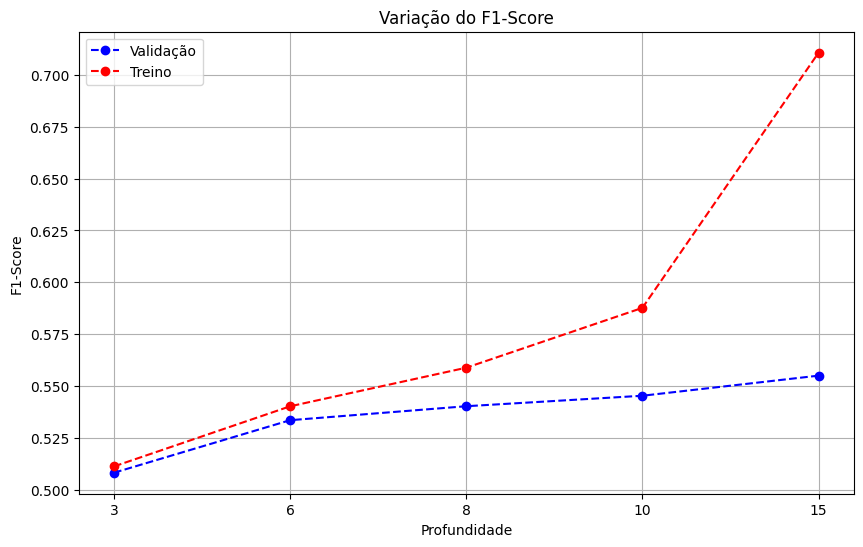

In [9]:
max_depths_as_labels = [str(cfg["max_depth"]) for cfg in configs_to_test]

plt.figure(figsize=(10,6))
plt.plot(max_depths_as_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_depths_as_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [6]:
X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train_full)

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_final, y_train_final = pipeline.fit_resample(X_train_full, y_train_full)

best_config = {'max_depth': 15, 'n_estimators': 100, 'learning_rate': 0.1, 'num_class': 3, 'objective': 'multi:softmax', 'seed': 42}

dt = XGBClassifier(**best_config)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)

f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

F1-Macro (Dados de Teste): 0.554


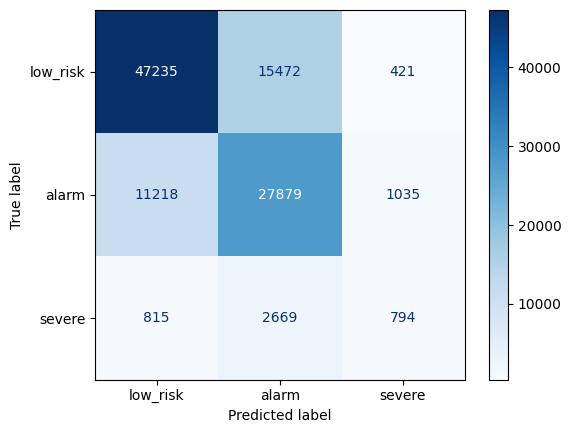

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

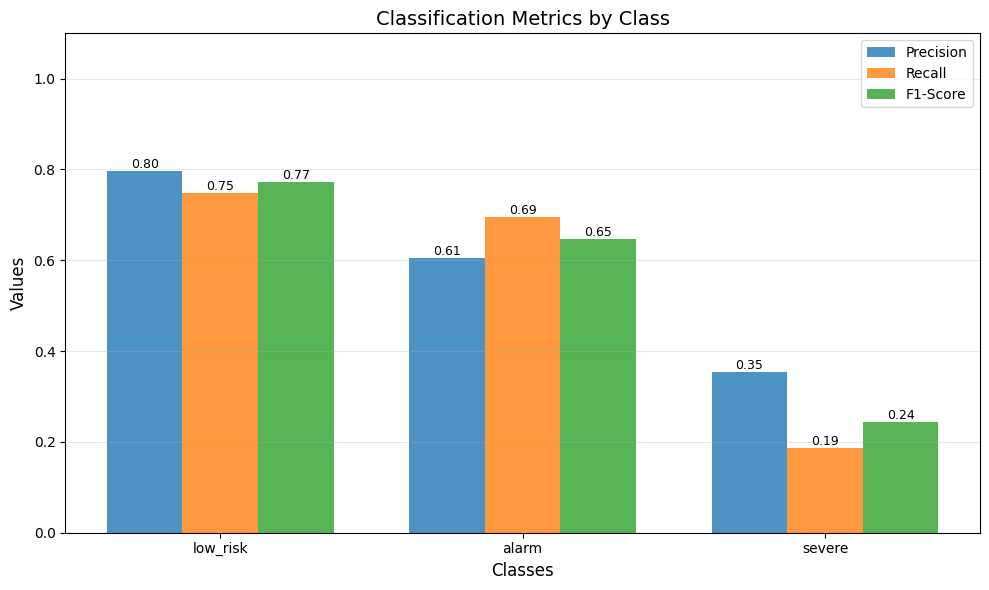

In [8]:
fig, ax, report_dict = plot_metrics_by_class(y_test, y_pred, target_names=target_names)

In [9]:
print_summary_metrics(report_dict)


              CLASSIFICATION METRICS (SUMMARY)              

Accuracy: 0.706

                        Precision       Recall     F1-Score
------------------------------------------------------------
Macro Avg                   0.585        0.543        0.554
Weighted Avg                0.708        0.706        0.704



In [10]:
print_summary_metrics_latex(report_dict)

\begin{table}
\caption{Classification Metrics (Accuracy: 0.706)}
\label{tab:metrics}
\begin{tabular}{lrr}
\toprule
Metric & Macro Avg & Weighted Avg \\
\midrule
Precision & 0.585 & 0.708 \\
Recall & 0.543 & 0.706 \\
F1-Score & 0.554 & 0.704 \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
print("Relatório de Classificação:\n", report)

Relatório de Classificação:
               precision    recall  f1-score   support

    low_risk       0.80      0.75      0.77     63128
       alarm       0.61      0.69      0.65     40132
      severe       0.35      0.19      0.24      4278

    accuracy                           0.71    107538
   macro avg       0.59      0.54      0.55    107538
weighted avg       0.71      0.71      0.70    107538

